In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/rice_leaf_diseases_dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image

### Type 1 of Finetuning

In [ ]:
vgg = VGG16(weights='imagenet', # Load the VGG16 model that was trained on the ImageNet dataset
            include_top=True, # Includes the fully connected layers
            # include_top=False, # removes the last fully connected layers so you can add your own classification layer
            input_shape=(224, 224, 3) # input image size expected by VGG16
)

In [ ]:
for layer in vgg.layers:
    print(f"{layer.name:<20} | Type: {type(layer).__name__:<20} | Trainable: {layer.trainable}")

input_layer          | Type: InputLayer           | Trainable: True
block1_conv1         | Type: Conv2D               | Trainable: True
block1_conv2         | Type: Conv2D               | Trainable: True
block1_pool          | Type: MaxPooling2D         | Trainable: True
block2_conv1         | Type: Conv2D               | Trainable: True
block2_conv2         | Type: Conv2D               | Trainable: True
block2_pool          | Type: MaxPooling2D         | Trainable: True
block3_conv1         | Type: Conv2D               | Trainable: True
block3_conv2         | Type: Conv2D               | Trainable: True
block3_conv3         | Type: Conv2D               | Trainable: True
block3_pool          | Type: MaxPooling2D         | Trainable: True
block4_conv1         | Type: Conv2D               | Trainable: True
block4_conv2         | Type: Conv2D               | Trainable: True
block4_conv3         | Type: Conv2D               | Trainable: True
block4_pool          | Type: MaxPooling2D       

In [ ]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential()
model.add(vgg)
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))

In [ ]:
# # It is from Functional API
# x = vgg.layers[-2].output
# output = Dense(1, activation = 'sigmoid')(x)
# model = Model(inputs = vgg.input, outputs=output)
# model.summary()

In [ ]:
# generators
dataset_dir = '/content/rice_leaf_diseases_dataset'

# Load training dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,  # 20% for validation
    subset='training',     # This is the training split
    seed=123               # Seed for reproducibility
)

# Load validation dataset
validation_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,  # 20% for validation
    subset='validation',   # This is the validation split
    seed=123               # Same seed as training for consistency
)

Found 180 files belonging to 3 classes.
Using 144 files for training.
Found 180 files belonging to 3 classes.
Using 36 files for validation.


In [ ]:
# Normalize images function
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)  # Scale pixel values from [0,255] to [0,1]
    return image, label

In [ ]:
# Apply normalization
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    # loss='binary_crossentropy',   # Use this only if 2 classes
    loss = 'sparse_categorical_crossentropy', # more than 2 classes
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds, epochs=1, validation_data=validation_ds, verbose=1)
history

5/5 ━━━━━━━━━━━━━━━━━━━━ 296s 58s/step - accuracy: 0.2970 - loss: 1.1002 - val_accuracy: 0.3333 - val_loss: 1.0991


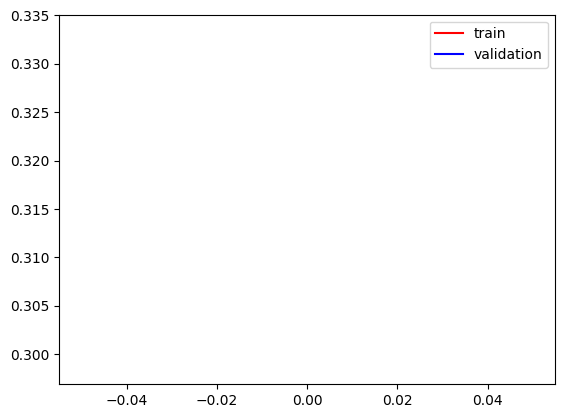

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

In [ ]:
# Path to test image (update with your actual image file)
img_path = '/content/rice_leaf_diseases_dataset/Leafsmut/BLAST1_001.jpg'

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # normalize

In [ ]:
# Predict
prediction = model.predict(img_array)

# Interpret result (binary classification)
label = "Bacterialblight" if prediction[0][0] > 0.5 else "Brownspot"
confidence = prediction[0][0]

# Show result
print(f"Predicted label: {label} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
Predicted label: Brownspot with confidence: 0.33


### Type 2 of Finetuning

In [ ]:
vgg_conv_base = VGG16(weights='imagenet', # Load the VGG16 model that was trained on the ImageNet dataset
            # include_top=True, # Includes the fully connected layers
            include_top=False, # removes the last fully connected layers so you can add your own classification layer
            input_shape=(224, 224, 3) # input image size expected by VGG16
)

In [ ]:
for layer in vgg_conv_base.layers:
    print(f"{layer.name:<20} | Type: {type(layer).__name__:<20} | Trainable: {layer.trainable}")

input_layer_4        | Type: InputLayer           | Trainable: True
block1_conv1         | Type: Conv2D               | Trainable: True
block1_conv2         | Type: Conv2D               | Trainable: True
block1_pool          | Type: MaxPooling2D         | Trainable: True
block2_conv1         | Type: Conv2D               | Trainable: True
block2_conv2         | Type: Conv2D               | Trainable: True
block2_pool          | Type: MaxPooling2D         | Trainable: True
block3_conv1         | Type: Conv2D               | Trainable: True
block3_conv2         | Type: Conv2D               | Trainable: True
block3_conv3         | Type: Conv2D               | Trainable: True
block3_pool          | Type: MaxPooling2D         | Trainable: True
block4_conv1         | Type: Conv2D               | Trainable: True
block4_conv2         | Type: Conv2D               | Trainable: True
block4_conv3         | Type: Conv2D               | Trainable: True
block4_pool          | Type: MaxPooling2D       

In [ ]:
vgg_conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential()
model.add(vgg_conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))

In [ ]:
# generators
dataset_dir = '/content/rice_leaf_diseases_dataset'

# Load training dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,  # 20% for validation
    subset='training',     # This is the training split
    seed=123               # Seed for reproducibility
)

# Load validation dataset
validation_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,  # 20% for validation
    subset='validation',   # This is the validation split
    seed=123               # Same seed as training for consistency
)

Found 180 files belonging to 3 classes.
Using 144 files for training.
Found 180 files belonging to 3 classes.
Using 36 files for validation.


In [ ]:
# Normalize images function
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)  # Scale pixel values from [0,255] to [0,1]
    return image, label

In [ ]:
# Apply normalization
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    # loss='binary_crossentropy',   # Use this only if 2 classes
    loss = 'sparse_categorical_crossentropy', # more than 2 classes
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds, epochs=1, validation_data=validation_ds, verbose=1)
history

5/5 ━━━━━━━━━━━━━━━━━━━━ 296s 58s/step - accuracy: 0.4928 - loss: 1.0570 - val_accuracy: 0.6944 - val_loss: 0.7620


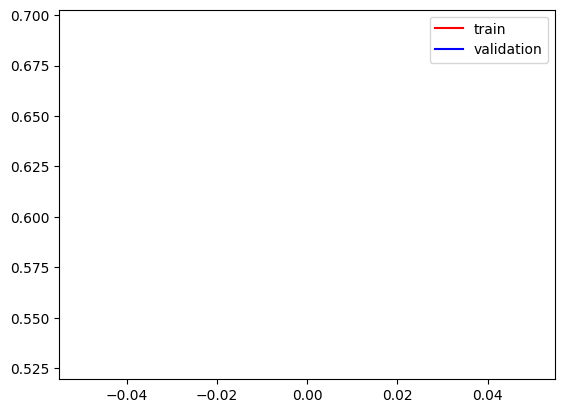

In [ ]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

In [ ]:
# Path to test image (update with your actual image file)
img_path = '/content/rice_leaf_diseases_dataset/Brownspot/BROWNSPOT1_001.jpg'

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # normalize

In [ ]:
# Predict
prediction = model.predict(img_array)

predicted_class = np.argmax(prediction, axis=1)[0]  # index of highest probability class
confidence = np.max(prediction)                    # probability of predicted class

print(f"Predicted class: {predicted_class} with confidence {confidence:.2f}")

# # Interpret result (binary classification)
# label = "Bacterialblight" if prediction[0][0] > 0.5 else "Brownspot"
# confidence = prediction[0][0]

# # Show result
# print(f"Predicted label: {label} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
Predicted class: 1 with confidence 0.69


### Type 3 Finetuning

In [ ]:
vgg_conv_base.layers

[<InputLayer name=input_layer_4, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

In [ ]:
vgg_conv_base.trainable = True

In [ ]:
vgg_conv_base.trainable

True

In [ ]:
set_trainable = False

for layer in vgg_conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [ ]:
for layer in vgg_conv_base.layers:
    print(f"{layer.name:<20} | Type: {type(layer).__name__:<20} | Trainable: {layer.trainable}")

input_layer_4        | Type: InputLayer           | Trainable: False
block1_conv1         | Type: Conv2D               | Trainable: False
block1_conv2         | Type: Conv2D               | Trainable: False
block1_pool          | Type: MaxPooling2D         | Trainable: False
block2_conv1         | Type: Conv2D               | Trainable: False
block2_conv2         | Type: Conv2D               | Trainable: False
block2_pool          | Type: MaxPooling2D         | Trainable: False
block3_conv1         | Type: Conv2D               | Trainable: False
block3_conv2         | Type: Conv2D               | Trainable: False
block3_conv3         | Type: Conv2D               | Trainable: False
block3_pool          | Type: MaxPooling2D         | Trainable: False
block4_conv1         | Type: Conv2D               | Trainable: False
block4_conv2         | Type: Conv2D               | Trainable: False
block4_conv3         | Type: Conv2D               | Trainable: False
block4_pool          | Type: MaxPo

In [ ]:
vgg_conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
model = Sequential()
model.add(vgg_conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))

In [ ]:
# generators
dataset_dir = '/content/rice_leaf_diseases_dataset'

# Load training dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,  # 20% for validation
    subset='training',     # This is the training split
    seed=123               # Seed for reproducibility
)

# Load validation dataset
validation_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,  # 20% for validation
    subset='validation',   # This is the validation split
    seed=123               # Same seed as training for consistency
)

Found 180 files belonging to 3 classes.
Using 144 files for training.
Found 180 files belonging to 3 classes.
Using 36 files for validation.


In [ ]:
# Normalize images function
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)  # Scale pixel values from [0,255] to [0,1]
    return image, label

In [ ]:
# Apply normalization
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    # loss='binary_crossentropy',   # Use this only if 2 classes
    loss = 'sparse_categorical_crossentropy', # more than 2 classes
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds, epochs=1, validation_data=validation_ds, verbose=1)
history

5/5 ━━━━━━━━━━━━━━━━━━━━ 117s 23s/step - accuracy: 0.4016 - loss: 1.0770 - val_accuracy: 0.7778 - val_loss: 0.7746


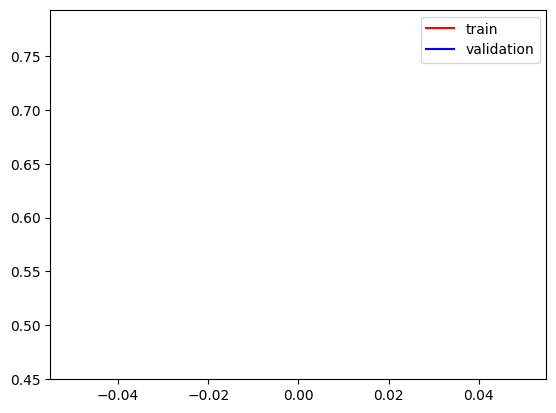

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

In [ ]:
# Path to test image (update with your actual image file)
img_path = '/content/rice_leaf_diseases_dataset/Bacterialblight/BACTERAILBLIGHT3_004.jpg'

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # normalize


In [ ]:
# Predict
prediction = model.predict(img_array)

predicted_class = np.argmax(prediction, axis=1)[0]  # index of highest probability class
confidence = np.max(prediction)                    # probability of predicted class

print(f"Predicted class: {predicted_class} with confidence {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicted class: 1 with confidence 0.38


### Transfer Learning and Finetuning with BERT

In [1]:
# !pip install -U datasets

Training a BERT model on emotion classification using text data

In [ ]:
from transformers import BertTokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from transformers import TrainingArguments, Trainer, BertForSequenceClassification
from transformers import BertModel
from datasets import load_dataset, ClassLabel

In [ ]:
dataset = load_dataset("emotion", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Step 1: Filter only desired labels (0=sadness, 1=joy, 3=anger)
dataset = dataset.filter(lambda x: x['label'] in [0, 1, 3]) # keeping only element swhere the value of 'label' key is either 0, 1, or 3.

# Step 2: Remap labels to 0,1,2
label_map = {0: 0, 1: 1, 3: 2}
dataset = dataset.map(lambda x: {"label": label_map[x["label"]]})

# Step 3: Properly update label class names using ClassLabel
new_label_feature = ClassLabel(num_classes=3, names=["sadness", "joy", "anger"])
dataset = dataset.cast_column("label", new_label_feature) # Treat "label" column as ClassLabel type with classes: sadness, joy, anger.

# Verify
print(dataset.features["label"].names)  # Fixed typo: 'fetures' → 'features' and added '.names'

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12187 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12187 [00:00<?, ? examples/s]

['sadness', 'joy', 'anger']


In [ ]:
# Train-test split
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9749
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2438
    })
})

In [ ]:
# Access training texts
train_texts = dataset['train']['text']
print(train_texts)

['i can finally stop feeling listless and like a waste of space', 'i can t help but feel a bit miserable', 'i feel like i captured all his sweet looks', 'i feel disheartened because i trust people to try to want to get to know me to not see through me and think i am boring or anything', 'i feel like i am losing confidence but for now i feel calm', 'im then left feeling quite embarrassed as i say that nothings new', 'i have absolutely no one to turn to when im feeling troubled and im not even exaggerating when i say that', 'im not going to lie ive been feeling rather happy lately which is odd for me since im rarely happy when school is in session', 'i am generally a pretty happy and positive person there are times when the nerves kick in and i am not feeling quite so happy and smiley', 'i feel the more im convinced that i dont want to let this go', 'i feel so welcomed in chicago', 'i feel pleased too that i am supporting people with small businesses who work from home buying gifts that 

In [ ]:
print(len(train_texts))

9749


In [ ]:
train_labels = dataset['train']['label']
train_labels

[0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 1,


In [ ]:
print(len(train_labels))

9749


In [ ]:
val_texts = dataset['test']['text']
val_labels = dataset['test']['label']

In [ ]:
print(len(val_texts))
print(len(val_labels))

2438
2438


**BERT Fine-Tuning Capabilities**

BERT can be fine-tuned for tasks like:

- **Text Classification**
- **Named Entity Recognition (NER)**
- **Question Answering**

because it is an **encoder-based model**.

However, for tasks such as:

- **Text Summarization**
- **Translation**

BERT is **not ideal**.  
Instead, models like **T5** and **BART**, which use **encoder-decoder architectures**, are more suitable for these generation-based tasks.


In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Define tokenization function
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",     # Ensures fixed length
        truncation=True,          # Truncates longer sequences
        max_length=64             # or 128, 256 etc., pick a consistent length
    )

In [ ]:
dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/9749 [00:00<?, ? examples/s]

Map:   0%|          | 0/2438 [00:00<?, ? examples/s]

In [ ]:
#  output only the columns 'input_ids', 'attention_mask', and 'label', and each of these will be converted to PyTorch tensor format.
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Load pre-trained model with new classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Transformer Blocks in BERT

BERT contains 12 Transformer blocks (in the base version), and each layer consists of the following components:

1. **Self-Attention Module**
2. **Intermediate Dense Layer**  
   (acts as a hidden expansion layer)
3. **Output Dense Layer + LayerNorm**


In [ ]:
for name, param in model.named_parameters():
    print(f"{name:50} | Shape: {tuple(param.shape)} | Trainable: {param.requires_grad}")

bert.embeddings.word_embeddings.weight             | Shape: (30522, 768) | Trainable: True
bert.embeddings.position_embeddings.weight         | Shape: (512, 768) | Trainable: True
bert.embeddings.token_type_embeddings.weight       | Shape: (2, 768) | Trainable: True
bert.embeddings.LayerNorm.weight                   | Shape: (768,) | Trainable: True
bert.embeddings.LayerNorm.bias                     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.query.weight   | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.query.bias     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.key.weight     | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.key.bias       | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.value.weight   | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.value.bias     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.output.den

In [ ]:
# Load model
model_for_cls = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3  # for 3-class classification
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Print parameter details
for name, param in model_for_cls.named_parameters():
    print(f"{name:50} | Shape: {tuple(param.shape)} | Trainable: {param.requires_grad}")

bert.embeddings.word_embeddings.weight             | Shape: (30522, 768) | Trainable: True
bert.embeddings.position_embeddings.weight         | Shape: (512, 768) | Trainable: True
bert.embeddings.token_type_embeddings.weight       | Shape: (2, 768) | Trainable: True
bert.embeddings.LayerNorm.weight                   | Shape: (768,) | Trainable: True
bert.embeddings.LayerNorm.bias                     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.query.weight   | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.query.bias     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.key.weight     | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.key.bias       | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.value.weight   | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.value.bias     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.output.den

In [ ]:
#  counts the total number of parameters in model
total_params = sum(p.numel() for p in model_for_cls.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 109484547


In [ ]:
#  counts the total number of trainable parameters in model
trainable_params = sum(p.numel() for p in model_for_cls.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 109484547


In [ ]:
print(model_for_cls.bert.embeddings)                     # Embedding layer

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
print(model_for_cls.bert.encoder.layer[11])              # Last Transformer block

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [ ]:
print(model_for_cls.classifier)                          # Classification head

Linear(in_features=768, out_features=3, bias=True)


In [ ]:
print(model_for_cls.config)                              # Model config: hidden size, dropout, etc.

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_output_1",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir="./logs",
    report_to="none"
)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable Weights & Biases logging

In [ ]:
# Trainer setup
trainer = Trainer(
    model=model_for_cls,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

In [ ]:
# Start training
trainer.train()

## Unfreeeze couple of last layer then train it


In [2]:
# !pip install --upgrade datasets

In [ ]:
from transformers import BertModel, BertTokenizer, PreTrainedModel, Trainer, TrainingArguments, BertConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from torch.utils.data import DataLoader
from datasets import load_dataset
import torch.nn as nn
import torch

In [ ]:
# dataset = load_dataset("emotion", split="train")
dataset = load_dataset("emotion")

In [ ]:
# Load pre-trained BERT
bert = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
# Freeze all layers
for param in bert.parameters():
    # print(param)
    param.requires_grad = False

In [ ]:
# Access encoder and layers
bert.encoder

BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSdpaSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
bert.encoder.layer

ModuleList(
  (0-11): 12 x BertLayer(
    (attention): BertAttention(
      (self): BertSdpaSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): BertOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [ ]:
# Print each encoder layer
# for layer in bert.encoder.layer[-2:]: # Last 2 encoder layers of BERT
for layer in bert.encoder.layer:
    print(layer)

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
 

In [ ]:
# Print second-last layer
for layer in bert.encoder.layer[-2:]: # Last 2 encoder layers of BERTLast 2 encoder layers of BERT
    print(layer)

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
 

In [ ]:
# Unfreeze last 2 layers
for layer in bert.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True
        print(param)

Parameter containing:
tensor([[ 7.1212e-04,  3.7436e-02, -8.1037e-03,  ..., -6.3732e-02,
         -9.5217e-04,  9.4325e-03],
        [-8.5306e-03,  2.1923e-02,  3.7563e-02,  ..., -2.5715e-02,
          4.9945e-02,  1.4635e-02],
        [ 1.7770e-02, -4.4673e-02,  2.7443e-02,  ...,  5.2510e-05,
         -2.2302e-02, -2.1553e-02],
        ...,
        [-2.2598e-03, -1.3400e-02,  1.9143e-02,  ..., -7.8677e-02,
          3.4674e-02, -2.0308e-02],
        [-3.6355e-02,  2.1299e-02,  9.1749e-03,  ..., -2.3351e-02,
          4.4595e-02, -1.0835e-01],
        [ 7.1196e-02, -2.0205e-02,  5.8498e-02,  ...,  1.0116e-01,
          1.8773e-02, -6.1368e-02]], requires_grad=True)
Parameter containing:
tensor([-3.6676e-02, -1.4497e-02, -3.8229e-02,  1.1834e-03, -5.4898e-02,
        -6.6086e-02, -1.0283e-02,  6.3277e-02, -1.7615e-02, -4.0525e-02,
        -4.5876e-03,  2.2352e-02, -2.2756e-02,  7.4079e-02,  9.4136e-03,
        -3.4196e-02,  6.0986e-02,  2.0791e-02,  3.0050e-02, -2.4763e-02,
         1.1

In [ ]:
# Define custom classifier class
class BertMultiClassClassifier(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased") # load the BERT encoder (no classification head) with pretrained weights
        self.classifier = nn.Linear(config.hidden_size, 3)  # add a linear layer on top of BERT to classify into 3 classes

        # Freeze all layers # Makes all of BERT's weights non-trainable by default.
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze last 2 layers # Allows the last 2 transformer blocks of BERT to be fine-tuned
        for layer in self.bert.encoder.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Unfreeze pooler # pooler converts BERT’s output into a fixed-size vector for classification, so allow it to be trained too
        for param in self.bert.pooler.parameters():
            param.requires_grad = True

        # Classifier should be trainable # classification head must be trainable (because it’s randomly initialized and not pretrained)
        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # Run BERT
        pooled_output = outputs.pooler_output # Get [CLS] pooled output
        logits = self.classifier(pooled_output) # Apply classifier head

        loss = None
        if labels is not None: #  Compute loss if labels are provided
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

In [ ]:
# Config and model
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
model = BertMultiClassClassifier(config)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./bert_last2layers_finetune',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="no",
    report_to="none",  # Disable wandb etc.
    logging_dir="./logs"
)

In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

In [ ]:
trainer.train()

In [ ]:
# Inference function
label_names = ["sadness", "joy", "anger"]

def predict_text(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        confidence = torch.softmax(logits, dim=1)[0][predicted_class].item()

    label_name = label_names[predicted_class]
    print(f"Text: {text}")
    print(f"Prediction: {label_name} (Confidence: {confidence:.2f})")
    return predicted_class, confidence

In [ ]:
# predictions
predict_text("I'm feeling really happy today.", model, tokenizer)
predict_text("I just want to cry and sleep.", model, tokenizer)